# Szeregi czasowe

Antoni Pięta

Jaub Ziarko

In [33]:
from pandas import read_csv
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Ładowanie datasetu

In [2]:
data_filename = 'result.csv'
dataset = read_csv(data_filename)

### Klumny i przykładowane dane z datasetu

In [3]:
dataset.head(7)

,datetime_from,avg(pm10),avg(humidity)
0,2020-03-07 20:00:00,61.372609,90.216522
1,2020-03-07 21:00:00,61.545652,92.691304
2,2020-03-07 22:00:00,64.220870,93.950000
3,2020-03-07 23:00:00,65.425217,94.855652
4,2020-03-08 00:00:00,65.676087,94.962609
5,2020-03-08 01:00:00,63.363913,95.100435
6,2020-03-08 02:00:00,60.751304,95.300000


### Informacje o datasecie

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330 entries, 0 to 1329
Data columns (total 3 columns):
datetime_from    1330 non-null object
avg(pm10)        1330 non-null float64
avg(humidity)    1330 non-null float64
dtypes: float64(2), object(1)
memory usage: 31.3+ KB


### Dodajemy kolumnę, która ma być używana do przewidywana - `actual`

In [5]:
steps = -1
dataset_for_prediction = dataset.copy()
dataset_for_prediction['actual'] = dataset_for_prediction['avg(pm10)'].shift(steps)

In [6]:
dataset_for_prediction.tail(15)

,datetime_from,avg(pm10),avg(humidity),actual
1315,2020-05-01 15:00:00,13.741304,81.459130,17.801739
1316,2020-05-01 16:00:00,17.801739,79.116087,24.442609
1317,2020-05-01 17:00:00,24.442609,78.803043,31.771304
1318,2020-05-01 18:00:00,31.771304,80.290870,39.994348
1319,2020-05-01 19:00:00,39.994348,84.018696,45.491739
1320,2020-05-01 20:00:00,45.491739,87.036522,46.817826
1321,2020-05-01 21:00:00,46.817826,88.330000,48.958261
1322,2020-05-01 22:00:00,48.958261,88.827826,50.524783
1323,2020-05-01 23:00:00,50.524783,88.843478,49.862609
1324,2020-05-02 00:00:00,49.862609,89.211739,48.520870


### Usuwamy wiersze z wartościami NaN

In [7]:
dataset_for_prediction=dataset_for_prediction.dropna()
dataset_for_prediction.tail(15)

,datetime_from,avg(pm10),avg(humidity),actual
1314,2020-05-01 14:00:00,10.544348,85.246522,13.741304
1315,2020-05-01 15:00:00,13.741304,81.459130,17.801739
1316,2020-05-01 16:00:00,17.801739,79.116087,24.442609
1317,2020-05-01 17:00:00,24.442609,78.803043,31.771304
1318,2020-05-01 18:00:00,31.771304,80.290870,39.994348
1319,2020-05-01 19:00:00,39.994348,84.018696,45.491739
1320,2020-05-01 20:00:00,45.491739,87.036522,46.817826
1321,2020-05-01 21:00:00,46.817826,88.330000,48.958261
1322,2020-05-01 22:00:00,48.958261,88.827826,50.524783
1323,2020-05-01 23:00:00,50.524783,88.843478,49.862609


### Ustawiamy date jako index 

In [8]:
dataset_for_prediction['datetime_from'] = pd.to_datetime(dataset_for_prediction['datetime_from'])
dataset_for_prediction.index = dataset_for_prediction['datetime_from']
dataset_for_prediction

,datetime_from,avg(pm10),avg(humidity),actual
datetime_from,,,,
2020-03-07 20:00:00,2020-03-07 20:00:00,61.372609,90.216522,61.545652
2020-03-07 21:00:00,2020-03-07 21:00:00,61.545652,92.691304,64.220870
2020-03-07 22:00:00,2020-03-07 22:00:00,64.220870,93.950000,65.425217
2020-03-07 23:00:00,2020-03-07 23:00:00,65.425217,94.855652,65.676087
2020-03-08 00:00:00,2020-03-08 00:00:00,65.676087,94.962609,63.363913
...,...,...,...,...
2020-05-02 00:00:00,2020-05-02 00:00:00,49.862609,89.211739,48.520870
2020-05-02 01:00:00,2020-05-02 01:00:00,48.520870,90.402174,44.915217
2020-05-02 02:00:00,2020-05-02 02:00:00,44.915217,91.183478,43.017391


### Rysowanie wykresów na podstawie danych

PM10

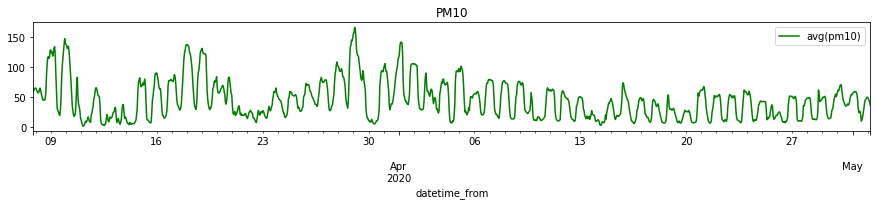

In [9]:
dataset_for_prediction['avg(pm10)'].plot(color='green', figsize=(15, 2))
plt.legend(['avg(pm10)'])
plt.title('PM10')
plt.show()

Humidity

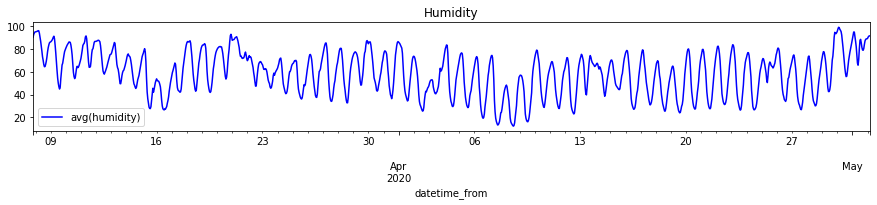

In [10]:
dataset_for_prediction['avg(humidity)'].plot(color='blue', figsize=(15, 2))
plt.legend(['avg(humidity)'])
plt.title('Humidity')
plt.show()

### Normalizacja danych wejściowych oraz target features

In [11]:
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(dataset_for_prediction[['avg(pm10)']])
scaled_input = pd.DataFrame(scaled_input)
X = scaled_input
X

,0
0,0.359750
1,0.360803
2,0.377075
3,0.384400
4,0.385926
...,...
1324,0.289741
1325,0.281580
1326,0.259648
1327,0.248105


In [12]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(dataset_for_prediction[['actual']])
scaler_output = pd.DataFrame(scaler_output)
y = scaler_output
y

,0
0,0.360803
1,0.377075
2,0.384400
3,0.385926
4,0.371862
...,...
1324,0.281580
1325,0.259648
1326,0.248105
1327,0.212903


### Zmiana nazw kolumn dla danych wejściowych i targetów

In [13]:
X.rename(columns={0: 'pm10'}, inplace=True)
y.rename(columns={0: 'pm10 prediction'}, inplace=True)
y.index=dataset_for_prediction.index
X.index=dataset_for_prediction.index

In [14]:
X

,pm10
datetime_from,
2020-03-07 20:00:00,0.359750
2020-03-07 21:00:00,0.360803
2020-03-07 22:00:00,0.377075
2020-03-07 23:00:00,0.384400
2020-03-08 00:00:00,0.385926
...,...
2020-05-02 00:00:00,0.289741
2020-05-02 01:00:00,0.281580
2020-05-02 02:00:00,0.259648


In [15]:
y

,pm10 prediction
datetime_from,
2020-03-07 20:00:00,0.360803
2020-03-07 21:00:00,0.377075
2020-03-07 22:00:00,0.384400
2020-03-07 23:00:00,0.385926
2020-03-08 00:00:00,0.371862
...,...
2020-05-02 00:00:00,0.281580
2020-05-02 01:00:00,0.259648
2020-05-02 02:00:00,0.248105


### Podział datasetu na dane treningowe i testowe

In [16]:
train_size = int(len(dataset) * 0.7)
test_size = int(len(dataset)) - train_size

train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()

### Dekompoyzcja szeregu czasowego na trend, sezonowość/cykliczność, szum

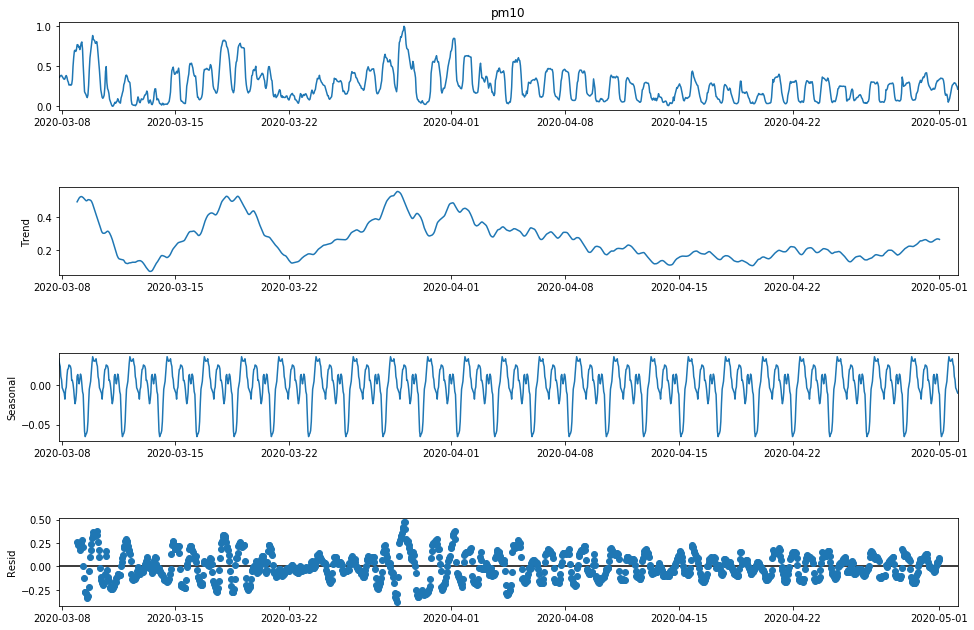

In [17]:
seas_d=sm.tsa.seasonal_decompose(X['pm10'],model='add',period=55);
fig=seas_d.plot()
fig.set_figheight(10)
fig.set_figwidth(16)
plt.show()

Additive model = Trend + Seasonality + Random Noise

### Sprawdzamy stacjonarość danych poprzez Augmented Dickey Fuller(ADF) test

Jeśli sprawimy że dane będą stacjonare to model będzie wykonywał przewidywania na podstawie tego że średnia oraz wariancją będą takie są przez przyszłe okresy.

In [18]:
def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)

In [19]:
y_test=y['pm10 prediction'][:train_size].dropna()
test_adf(y_test, 'pm10')

Strong evidence for  Null Hypothesis
Accept Null Hypothesis - Data is not Stationary
Data is NOT Stationary for pm10


### Dane stacjonarne - różnicowanie

In [20]:
test_adf(y_test.diff(), 'pm10')

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary pm10


### Budowanie modelu

ACF plot: wykres słupkowy współczynników korelacji między szeregiem czasowym a jego własnym opóźnieniem

PACF plot: wykres słupkowy współczynników częściowej korelacji między szeregiem czasowym a jego własnym opóźnieniem

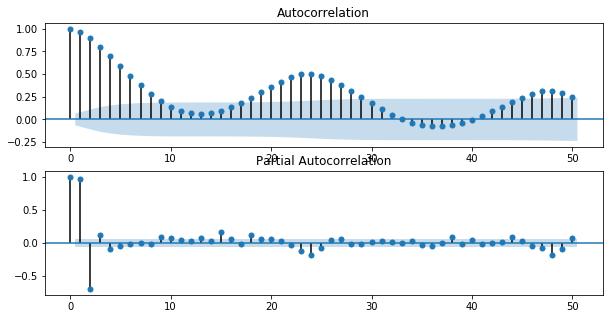

In [21]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(y_test, lags=50, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_test, lags=50, ax=ax[1])
plt.show()

### Funkcja auto_arima która dobiera najlepsze parametry modelu ARIMA do szeregu czasowego.

Losowo wybiera i sprawdza kolejne paraemtry dobierając w ten sposób te najlepsze. Próbuje zminimalizować partykę AIC (Akaike Information Criterion) - dobiera parametry dla ktorych jest najmniejsza.

In [22]:
step_wise=auto_arima(train_y, 
 exogenous= train_X,
 start_p=1, start_q=1, 
 max_p=7, max_q=7, 
 d=1, max_d=7,
 trace=True, 
 error_action='ignore', 
 suppress_warnings=True, 
 stepwise=True)

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-3359.302, BIC=-3335.131, Time=0.467 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=-3337.017, BIC=-3322.514, Time=0.088 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-3360.438, BIC=-3341.102, Time=0.235 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-3360.817, BIC=-3341.480, Time=0.217 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=-3339.013, BIC=-3329.344, Time=0.122 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=-3359.282, BIC=-3335.111, Time=0.523 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=-3390.049, BIC=-3361.045, Time=1.051 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=-3355.262, BIC=-3321.423, Time=0.743 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=-3355.326, BIC=-3321.488, Time=0.914 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=-3357.283, BIC=-3328.278, Time=0.930 seconds
Fit ARIMA(2,1,1)

In [23]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  930
Model:               SARIMAX(1, 1, 2)   Log Likelihood                1701.025
Date:                Fri, 08 May 2020   AIC                          -3390.049
Time:                        10:46:18   BIC                          -3361.045
Sample:                    03-07-2020   HQIC                         -3378.986
                         - 04-15-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.001e-05   7.98e-05     -0.251      0.802      -0.000       0.000
pm10           0.5541      0.064      8.657      0.000       0.429       0.680
ar.L1          0.8776      0.070     12.515      0.000       0.740       1.015
ma.L1         -0.6878      0.048    -14.207      0.000      -0.783      -0.593
ma.L2         -0.2555      0.046     -5.610      0.000      -0.345      -0.166
sigma2         0.0015   4.73e-05     31.806      0.000       0.001       0.002
===================================================================================
Ljung-Box (Q):                      204.11   Jarque-Bera (JB):               593.04
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                            -0.24
Prob(H) (two-sided):                  0.02   Kurtosis:                         6.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Zasugerowany został SARIMAX oraz wartości dla p,d,q wynoszące odpowiednio 1,1,2.

### Trenowanie modelu

In [24]:
model = SARIMAX(train_y, exog=train_X, order=(1,1,2), enforce_invertibility=False, enforce_stationarity=False)

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [25]:
results = model.fit()

### Predykcja

predict()

podajemy koniec oraz początek wraz ze zmienną exog, na podstawie której dokonana zostanie predykcja

In [26]:
predictions= results.predict(start=train_size, end=train_size+test_size+(steps)-1,exog=test_X)

### Stworzenie wykresu dla uzyskanej predykcji 

In [27]:
act= pd.DataFrame(scaler_output.iloc[train_size:, 0])

In [28]:
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['actual'] = act['pm10 prediction']
predictions.rename(columns={0:'Pred'}, inplace=True)

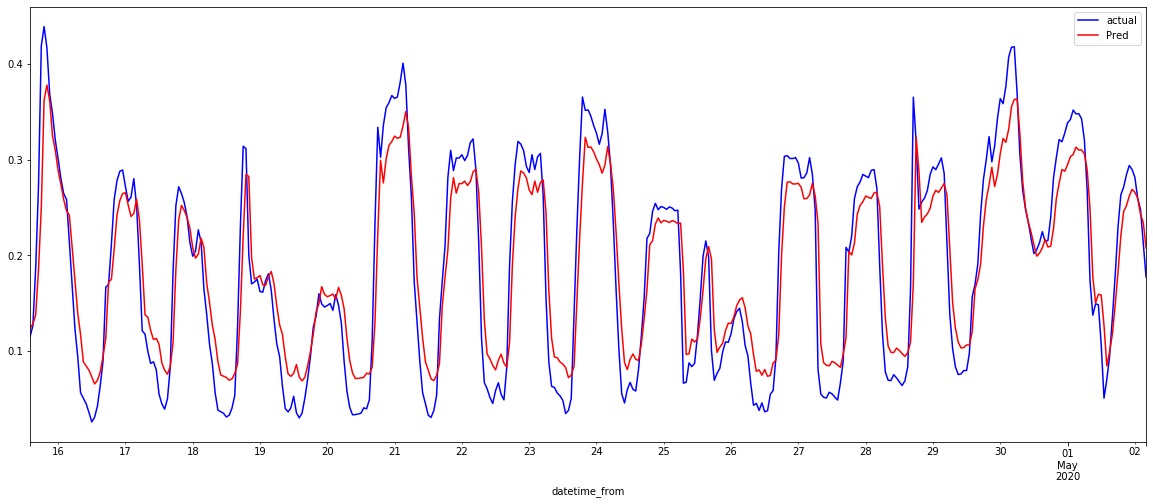

In [29]:
predictions['actual'].plot(figsize=(20,8), legend=True, color='blue')
predictions['Pred'].plot(legend=True, color='red', figsize=(20,8))

### Ewaluacja błędu

In [30]:
from statsmodels.tools.eval_measures import rmse
error=rmse(predictions['Pred'], predictions['actual'])
error

0.04205322565754593

### Skalowanie do oryginalnych wartości

In [31]:
trainPredict = sc_out.inverse_transform(predictions[['Pred']])
testPredict = sc_out.inverse_transform(predictions[['actual']])